# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing the NLP libraries
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet') # download for lemmatization
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

#importing database engine library
from sqlalchemy import create_engine

#importing the sklearn libraries
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import jaccard_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.metrics import fbeta_score, make_scorer
import pickle

import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:

# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql("SELECT * FROM MessagesCategories", engine)

#Viewing top 5 records of the dataframe from the MessageCategories table
df.head(5)

#Asssigning the X and Y variable so that it can be used to test and train the dataset,
# dropping the object types values keeping only one hot encoded labels

#Storing message column of the dataframe into the X variable
X = df.message.values

#Storing the remaining columns into the Y variable
Y = df.iloc[:,4:]


In [4]:
#Checking the Y variable to see if related column has only binary values of 0 and 1 
Y.related.unique()

array([1, 0])

In [5]:
#Checking the X variable 
X[1:3]

array(['Is the Hurricane over or is it not over',
       'Looking for someone but no name'], dtype=object)

In [6]:
target_names  = Y.columns
target_names

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

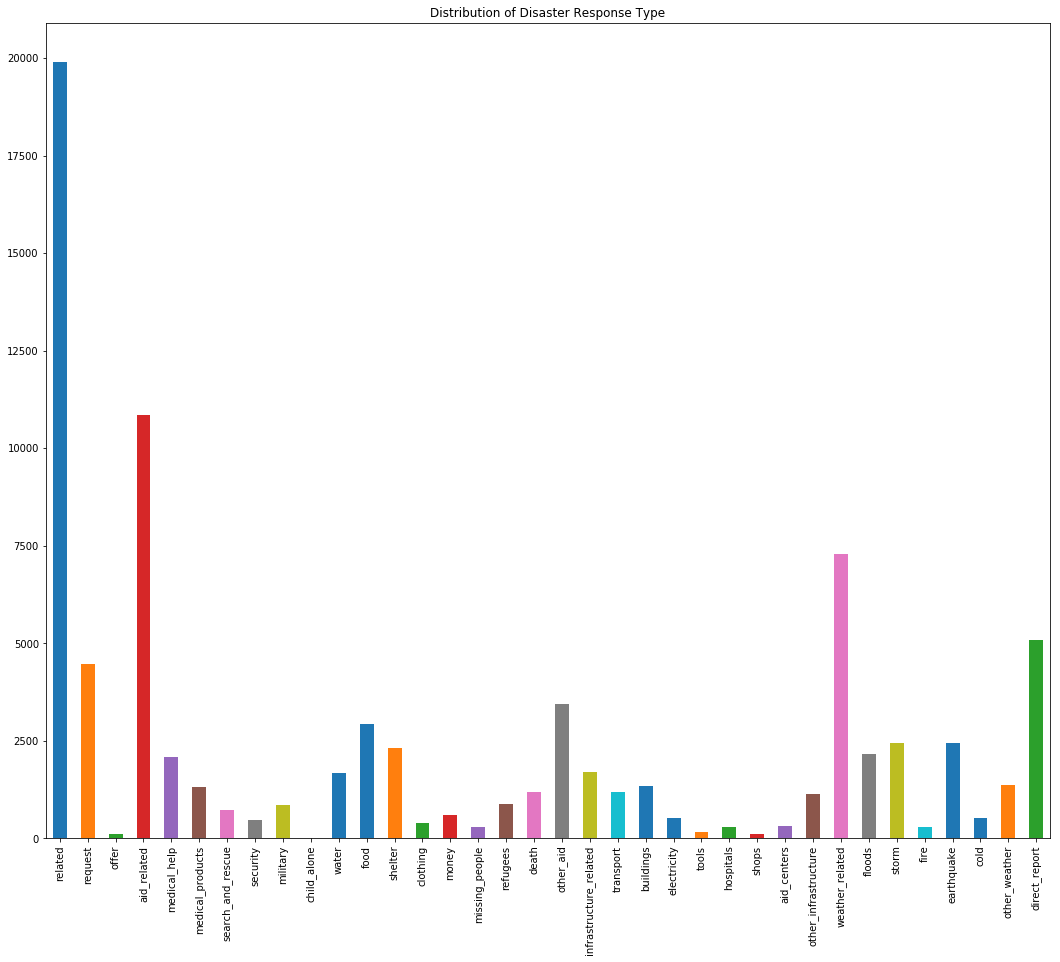

In [7]:
plt.figure(figsize=(18,15))
Y.sum().plot(kind='bar')
plt.title("Distribution of Disaster Response Type")
plt.savefig("Distribution of Disaster Response Type.png",dpi=500)

### 2. Write a tokenization function to process your text data

In [17]:
# A tokenization function to process text data the Disaster Response Messages from the Dataframe 
def tokenize(text):
    
    """Tokenization function."""
    """Receives as input as raw text"""
   
    """"Does the following task"""
    """Normalizetext, Stop words removal, Stemming and Lemmatizing."
    """""""Returns tokenized text"""
    
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        #---Inside the For loop and replacing the url place holder---
        text = text.replace(url, "urlplaceholder")
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
       
        # ---Removing the Stop Words---     
        if tok in stopwords.words("english"):
            continue
            
        # ---Reducing words to their Stems---        
        tok = PorterStemmer().stem(tok)
        
        # ---Reduce words to their root form---        
        tok = lemmatizer.lemmatize(tok).lower().strip()
        
        #---Appending the clean tokens to the list---"
        clean_tokens.append(tok)
        
    clean_tokens = [tok for tok in clean_tokens if tok.isalpha()]
    return clean_tokens

#printing and checking the tokenize function for verfiy to see it is working correctly
print(X[1])
print(tokenize(X[1]))

Is the Hurricane over or is it not over
['is', 'hurrican']


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [71]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier())
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [72]:
#Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.33, random_state=42)

In [73]:
#Viewing the X Train dataset
X_train[1:5]

array(['I was flooded in Port-au-Prince. Now I live in Gonaives. I need help. ',
       "SPCA made sure our doggie Manhattan has his emergency stash of food. #frankenstorm #hurricanesandy #food http://t.co/ldCyMlGDI got Reese's, mini muffins &amp; water. I'm set for sandy.So about these hurricane festivities ..Chillin' with mi hermano for",
       'I went to all digicel offices to find a motorola Wx, 160, I can not find one. ',
       "* Delivery of more than 41 tons of therapeutic milk and 1.5 tons of Plumpy'nut to treat children with acute severe malnutrition in 31 therapeutic feeding centres operated by UNICEF partners."], dtype=object)

In [74]:
#Viewing the X Test dataset
X_test[1:5]

array([ 'A positive development is that cooling has been restored to the reactor pressure vessels in Units 5 and 6.',
       'Witnesses say 200 to 500 people have so far died of exposure in and around the squalid displacement camps near Herat, while the local branch of the UN High Commissioner for Refugees (UNHCR) says that the 35 centimetres (one foot) of snow had contributed to the deaths of at least 322 people.',
       'The 15-nation Economic Community of West African States (ECOWAS) already cut off the landlocked country which depends heavily on imported fuel and froze access to its bank account in Dakar.',
       'and in addition what time will it be possible for me to sleep in my house?'], dtype=object)

In [75]:
#Viewing the y Train dataset
Y_train[1:5]

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
4828,1,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
12505,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
5027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18022,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
#Viewing the y test train dataset
Y_test[1:5]

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
25322,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22191,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
18442,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#Train pipeline
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [79]:
#Predicting the Y variable
Y_pred = pipeline.predict(X_test)

In [80]:
# calling sklearn's classification_report on each column.
for i_value, col in enumerate(Y.columns):   
    print("column_name----->",col,classification_report(Y_test[col], Y_pred[:,i_value]))

overall_avg_value = (Y_pred == Y_test).mean().mean()
print("Accuracy Overall:\n", overall_avg_value)

column_name-----> related              precision    recall  f1-score   support

          0       0.61      0.56      0.58      2118
          1       0.86      0.89      0.87      6534

avg / total       0.80      0.80      0.80      8652

column_name-----> request              precision    recall  f1-score   support

          0       0.89      0.98      0.94      7180
          1       0.82      0.43      0.57      1472

avg / total       0.88      0.89      0.87      8652

column_name-----> offer              precision    recall  f1-score   support

          0       1.00      1.00      1.00      8614
          1       0.00      0.00      0.00        38

avg / total       0.99      1.00      0.99      8652

column_name-----> aid_related              precision    recall  f1-score   support

          0       0.72      0.89      0.80      5107
          1       0.76      0.49      0.60      3545

avg / total       0.74      0.73      0.71      8652

column_name-----> medical_help    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [81]:
# Getting the pipeline parameters
pipeline.get_params()


{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7f4b59323378>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None, verbose=0,
               warm_

In [85]:
parameters = {'clf__n_estimators': [12],
             'clf__min_samples_split': [2]}

cv = GridSearchCV(pipeline, parameters,verbose = 3,n_jobs=-1)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [86]:
# Fitting the model again after Cross Validation 
cv.fit(X_train, Y_train)

Y_pred = cv.predict(X_test)

for i_value, col in enumerate(Y.columns):
    print("Column Name---->",col,classification_report(Y_test[col], Y_pred[:,i_value]))

avg = (Y_pred == Y_test).mean().mean()
print("Accuracy Overall:\n", avg)
  

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__min_samples_split=2, clf__n_estimators=12 ..................
[CV]  clf__min_samples_split=2, clf__n_estimators=12, score=0.2838599487617421, total= 1.8min
[CV] clf__min_samples_split=2, clf__n_estimators=12 ..................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV]  clf__min_samples_split=2, clf__n_estimators=12, score=0.27805294619982923, total= 1.8min
[CV] clf__min_samples_split=2, clf__n_estimators=12 ..................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.9min remaining:    0.0s


[CV]  clf__min_samples_split=2, clf__n_estimators=12, score=0.29142466689443114, total= 1.8min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.7min finished


Column Name----> related              precision    recall  f1-score   support

          0       0.65      0.52      0.58      2118
          1       0.85      0.91      0.88      6534

avg / total       0.80      0.81      0.81      8652

Column Name----> request              precision    recall  f1-score   support

          0       0.89      0.98      0.94      7180
          1       0.82      0.43      0.56      1472

avg / total       0.88      0.89      0.87      8652

Column Name----> offer              precision    recall  f1-score   support

          0       1.00      1.00      1.00      8614
          1       0.00      0.00      0.00        38

avg / total       0.99      1.00      0.99      8652

Column Name----> aid_related              precision    recall  f1-score   support

          0       0.72      0.90      0.80      5107
          1       0.77      0.49      0.60      3545

avg / total       0.74      0.73      0.72      8652

Column Name----> medical_help         

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [87]:
pickle.dump(cv, open("classifier.pkl", 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.